In [1]:
import networkx as nx
import osmnx as ox
import random
import copy
import igraph as ig
import numpy as np
import math
import random
import time
import pickle as pk
from tqdm.auto import tqdm

In [2]:
#Algorithm the same as the one in their code with some unnessecary bits  removed. 
#Enumerates all of the connections between points of interest in graph and sums over their weights
def get_poipairs_by_distance(G, pois_indices):
    # Get sequences of nodes and edges in shortest paths between all pairs of pois
    poi_nodes = []
    poi_edges = []
    for c, v in enumerate(pois_indices):
        # Possible cost parameters we could add to weight could be calculated here. 
        #We'd have to implement a "get shortest paths  weighted on accident data etc." 
        # could also include node weights 
        poi_nodes.append(G.get_shortest_paths(v, pois_indices[c:], output = "vpath"))
        poi_edges.append(G.get_shortest_paths(v, pois_indices[c:], output = "epath"))

    # Sum up weights (distances) of all paths
    poi_dist = {}
    for paths_n, paths_e in zip(poi_nodes, poi_edges):
        for path_n, path_e in zip(paths_n, paths_e):
            # Sum up distances of path segments from first to last node
            #would have to use distances incorporating parameters if we were to use them here. 
            path_dist = sum([G.es[e]['weight'] for e in path_e])
            if path_dist > 0:
                poi_dist[(path_n[0],path_n[-1])] = path_dist

    temp = sorted(poi_dist.items(), key = lambda x: x[1])
    # Back to ids
    poipairs = []
    for p in temp:
        poipairs.append([(G.vs[p[0][0]]["id"], G.vs[p[0][1]]["id"]), p[1]])

    return poipairs

In [3]:
def greedy_triangulation(GT, poipairs, prune_factor = 1, prune_measure = "betweenness"):
    for poipair, poipair_distance in poipairs:
            try:
                poipair_ind = (GT.vs.find(id = poipair[0]).index, GT.vs.find(id = poipair[1]).index)
            except:
                print(poipair)
                for v in GT.vs:
                    print(v['id'])
                
            if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
                GT.add_edge(poipair_ind[0], poipair_ind[1], weight = poipair_distance)

        # Get the measure for pruning
    #if prune_measure == "betweenness":
    BW = GT.edge_betweenness(directed = False, weights = "weight")
    #here is where we can include some other attributes: for instance BW = betweenness/log(accident likelihood)
    qt = np.quantile(BW, 1-prune_factor)
    sub_edges = []
    for c, e in enumerate(GT.es):
        if BW[c] >= qt: 
            sub_edges.append(c)
            #we only keep edge c if it is in the pf percentile of edges in our metric (0 = no edges, 1 = all edges from GT)
        GT.es[c]["bw"] = BW[c]
        GT.es[c]["width"] = math.sqrt(BW[c]+1)*0.5
    GT = GT.subgraph_edges(sub_edges)
    return GT


In [4]:
 # Get node pairs we need to route, sorted by distance
# allows us to only includ relevant pairs in 
def route_node_pairs(GT):
    routenodepairs = {}
    for e in GT.es:
        routenodepairs[(e.source_vertex["id"], e.target_vertex["id"])] = e["weight"]
    routenodepairs = sorted(routenodepairs.items(), key = lambda x: x[1])

    # Do the routing
    GT_indices = set()
    for poipair, poipair_distance in routenodepairs:
        poipair_ind = (G.vs.find(id = poipair[0]).index, G.vs.find(id = poipair[1]).index)
        sp = set(G.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights = "weight", output = "vpath")[0])
        GT_indices = GT_indices.union(sp)

    GT_final = G.induced_subgraph(GT_indices)
    return GT_final

In [5]:
#the below classes are ripped from the code. its an intersection function which could probably be optimized better but it definitely works :)
class MyPoint:
    def __init__(self,x,y):
        self.x = x
        self.y = y

In [6]:
def new_edge_intersects(G, enew):
    """Given a graph G and a potential new edge enew,
    check if enew will intersect any old edge.
    """
    E1 = MyPoint(enew[0], enew[1])
    E2 = MyPoint(enew[2], enew[3])
    for e in G.es():
        O1 = MyPoint(e.source_vertex["x"], e.source_vertex["y"])
        O2 = MyPoint(e.target_vertex["x"], e.target_vertex["y"])
        if segments_intersect(E1, E2, O1, O2):
            return True
    return False

In [7]:
def segments_intersect(A,B,C,D):
    """Check if two line segments intersect (except for colinearity)
    Returns true if line segments AB and CD intersect properly.
    Adapted from: https://stackoverflow.com/questions/3838329/how-can-i-check-if-two-segments-intersect
    """
    if (A.x == C.x and A.y == C.y) or (A.x == D.x and A.y == D.y) or (B.x == C.x and B.y == C.y) or (B.x == D.x and B.y == D.y): return False # If the segments share an endpoint they do not intersect properly
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def ccw(A,B,C):
    return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)

In [8]:
#craete a deepcopy of the original graph with no edges

#def greedy_triangulation_subgraph(G, pois_indices = [], pois_method = pass):
def gt_from_scratch(G, num_pois, prune_factor = 1):
    pois_indices =  random.sample(range(1, len(G.vs)-1), num_pois)
    #pois_indices = list(range(0,num_pois))
    #pois_indices =  [100,1000,5000,9,10,15,250,60,150]
    #print(pois_indices)
    G_temp = copy.deepcopy(G)
    for e in G_temp.es: # delete all edges
        G_temp.es.delete(e)
    GT = copy.deepcopy(G_temp.subgraph(set(pois_indices)))
    poipairs = get_poipairs_by_distance(G, pois_indices)
    #print(poipairs)
    GT = greedy_triangulation(GT, poipairs)
    GT_final = route_node_pairs(GT)
    return GT_final


In [9]:
#runs the function n  times on graph G with num_pois random pois returns a 
def run_X_times(G, num_pois, n = 10):
    times = []
    for i in range(n):
        start_time = time.time()
        GT_final = gt_from_scratch(G, num_pois)
        times.append(time.time() - start_time)
    return times



In [10]:
gdf = ox.geocode_to_gdf('rochester, ny')
#running on the osmnx graph with random pois for now
g  = ox.graph_from_polygon(gdf.geometry[0], network_type='bike')
G = ig.Graph.from_networkx(g)
for e in G.es:
    e['weight'] = e['length']
for i,v in enumerate(G.vs):
    v['id'] = i
generated_network = gt_from_scratch(G, 100, prune_factor = 0.8)
generated_network.summary()

C:\Users\hoang\miniconda3\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


'IGRAPH D-W- 2971 6447 -- \n+ attr: created_date (g), created_with (g), crs (g), simplified (g), _nx_name (v), highway (v), id (v), street_count (v), x (v), y (v), access (e), bridge (e), geometry (e), highway (e), junction (e), lanes (e), length (e), maxspeed (e), name (e), oneway (e), osmid (e), ref (e), service (e), tunnel (e), weight (e), width (e)'

In [11]:
pois_times = []
poi_n = [25, 50, 100, 200, 500]

In [ ]:
for k in tqdm(poi_n):
    pois_times.append(run_X_times(G,k,10))


In [14]:
#don't have the file so i pasted them in
pois_times = [[5.153523921966553, 4.872383117675781, 4.866201639175415, 4.955097675323486, 5.004591226577759, 4.924658298492432, 4.913832664489746, 5.051943302154541, 4.952014446258545, 4.905686140060425]
,[6.655368089675903, 6.430932283401489, 6.5818564891815186, 6.896301984786987, 6.660094261169434, 8.36094045639038, 7.3024561405181885, 6.674937963485718, 6.336331367492676, 6.501245498657227]
,[13.96689510345459, 14.894343614578247, 14.307453870773315, 14.952030658721924, 14.426907062530518, 13.900016069412231, 14.777370691299438, 14.391879320144653, 13.256445169448853, 13.320914506912231]
,[48.347018241882324, 48.39953899383545, 52.27925515174866, 49.574729681015015, 47.71937704086304, 49.62196326255798, 47.58820390701294, 46.4927773475647, 51.84807276725769, 49.06229782104492]
,[498.2538764476776, 499.85614013671875, 509.4761872291565, 471.96419978141785, 467.4112243652344, 479.4652645587921, 498.9530463218689, 493.69329023361206, 481.68253087997437, 467.08037400245667]]

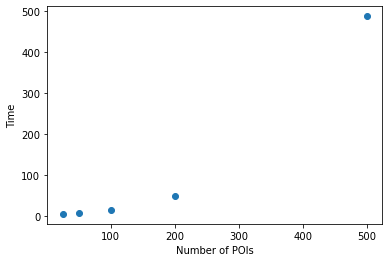

In [15]:
import matplotlib.pyplot as plt
means = [np.mean(times) for times in pois_times]
plt.scatter(poi_n, means)
plt.xlabel('Number of POIs')
plt.ylabel('Time')
plt.show()